In [1]:
import timm
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import fastcore.all as fc
import numpy as np
import torchvision
from PIL import Image
from io import BytesIO


In [2]:
import matplotlib.pyplot as plt

In [3]:
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
anime_url = 'https://cdn.donmai.us/sample/90/46/__original_drawn_by_aaaa_quad_a__sample-9046147a2e9255716919f28e0f696435.jpg'
cat_url = 'https://hips.hearstapps.com/hmg-prod/images/beautiful-smooth-haired-red-cat-lies-on-the-sofa-royalty-free-image-1678488026.jpg?crop=1xw:0.84415xh;center,top'

In [4]:
def download_image(url):
    img = fc.urlread(url, decode=False)
    return Image.open(BytesIO(img))

In [5]:
img = download_image(cat_url)

In [6]:
def create_transforms(img, size=0, mean = [0,0,0], std = [0,0,0]):
    transforms = torchvision.transforms
    preprocess = torchvision.transforms.Compose([
                  transforms.Resize(size),
                  transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize(mean = mean, std = std)])
    return preprocess

In [7]:
preprocess = create_transforms(img, size=(224,224), mean =[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225] )

In [8]:
def show_image(img, ax=None, figsize = None, title=None, noFrame = True, **kwargs):
    #check if image is a tensor
    if type(img) != torch.Tensor:
        img = np.array(img)
    else:
        for attr in [ 'detach', 'cpu', 'detach']:
            #if has cpu, detach or cpu methods we detach
            if hasattr(img, attr):
                img = img.detach().cpu()
            #if the channels are first we check it is less than 5 and premute if it is
            if len(img.shape)==3 and img.shape[0] <5:
                img = img.permute(1,2,0)
    if ax is None:
        _,ax = plt.subplots(figsize=figsize)
    ax.imshow(img, **kwargs)
    if title is not None:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    if noFrame:
        ax.axis('off')
    return ax
    

<Axes: >

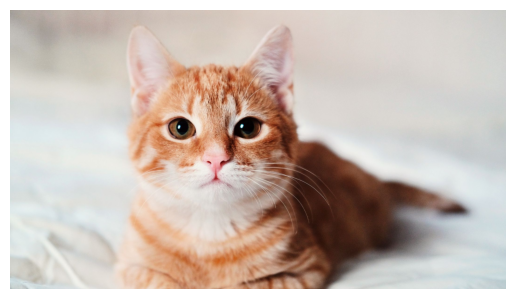

In [9]:
show_image(img)

# We want to be able to calculate GradCam with Any Model
Wen want to be able to select a model and a layer and get the output then, using hooks

# Hooks

In [10]:
from functools import  partial

In [11]:
class Hook:
    def __init__(self, m, func):
        self.data = None
        self.hook = m.register_forward_hook(partial(func, self))
        
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.remove()
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()
        
    @property
    def act(self):
        return self.data
    @property
    def grad(self):
        return self.data.grad

# Model
Normally you just want choose a layer and a target class, but I want to use the full model to get what the model thinks it is. 

In [12]:
def hook_func(hook, mod, inp, out):
    hook.data = out
    out.requires_grad_(True)
    out.retain_grad()

In [13]:
def inference(model, img):
    return model(img)

In [14]:
class GradCam:
    def __init__(self, model, layer, model_code, layer_idx = None, transforms = None):
        self.transforms = transforms
        self.model = model
        self.model.eval()
        self.model_predict = model_code
        if not isinstance(layer, list):
            layer = [layer]
        for l in layer:
            mod = getattr(self.model, l)
        if layer_idx is not None:
            mod = mod[layer_idx]
        self.mod = mod
        self.act, self.grad = None, None
    def predict(self,  img, cls=None):
        img = self.transforms(img)
        if len(img.shape)!=4:
            img = img[None,...]
            
        with Hook(self.mod, hook_func) as hook:
            output = self.model_predict(self.model, img)
            if cls is None:
                cls = output.argmax()
            output[:,cls].backward()
            self.act = hook.act.detach().squeeze().cpu()
            self.grad = hook.grad.detach().squeeze().cpu()
        return output
        # self.hook.remove()
    def gradcam_vis(self, img, ):
        cam_map = self.gradcam()
        ax = show_image(img)
        ax.imshow(cam_map.squeeze().detach().numpy(), alpha=0.6, extent=(0,img.width, img.height,0),
              interpolation='bilinear', cmap='magma');
        
    def gradcam(self):
        act = self.act
        grad = self.grad
        
        w = grad.mean(dim=[1,2], keepdim=True)
        cam_map = (w * act).sum(0)
        
        return torch.clamp(cam_map, min=0)
        

In [15]:
vgg=  timm.create_model('vgg16', pretrained=True)
a = GradCam(vgg, 'features', inference,transforms=preprocess)

In [16]:
a.predict(img)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([[-2.3791e+00,  1.4712e+00,  7.5955e-01,  1.6949e+00, -7.9513e-02,
          1.5045e+00, -1.1362e+00,  6.7324e-01,  3.5434e+00, -1.4569e+00,
          6.9529e-01, -1.7174e+00,  2.7614e+00, -6.1255e-01, -2.2834e+00,
         -3.5004e-01, -1.1431e+00, -7.5774e-01, -2.3920e+00, -2.5237e+00,
         -1.5722e+00,  3.0290e-01, -1.6181e+00,  4.5623e-02, -9.5257e-01,
         -3.9765e+00, -1.7466e+00, -1.1118e+00, -3.3536e+00, -1.0820e+00,
         -1.3814e+00, -1.9906e+00, -8.0828e-01, -1.1163e+00, -1.8104e+00,
         -3.7103e+00, -9.4874e-02, -2.5780e+00,  1.8460e+00, -1.8950e+00,
         -4.8101e-01, -3.5137e-01, -2.3828e-01,  1.2418e+00, -2.2235e+00,
         -2.7093e+00, -1.6071e+00, -1.9690e+00, -2.0927e+00, -3.7137e+00,
         -2.4022e+00, -1.3974e+00, -1.5612e-02, -1.6922e+00, -6.0717e-01,
         -3.1812e+00, -1.3594e+00, -1.7282e+00, -8.4860e-01, -8.1244e-01,
          2.4160e-01,  9.4531e-01, -6.5270e-01,  1.5204e+00, -2.6963e+00,
         -2.5955e+00, -1.9355e-01, -1.

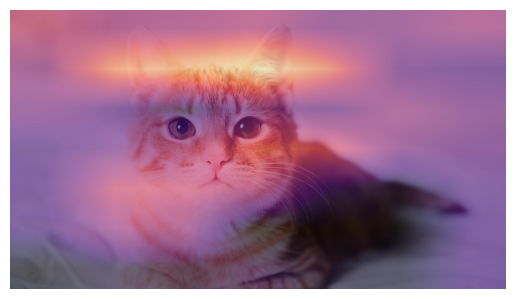

In [17]:
cam_map3 = a.gradcam_vis(img)

# Resnet

In [18]:
resnet=  timm.create_model('resnet50', pretrained=True)

In [19]:
a = GradCam(resnet, 'layer4', inference,transforms=preprocess)

In [20]:
img = download_image(cat_url)

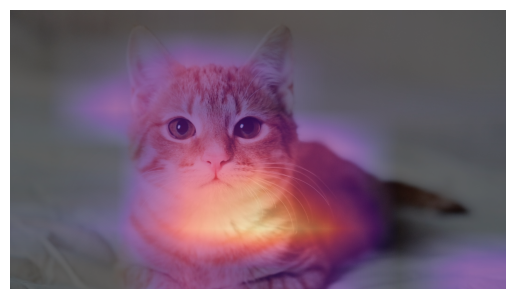

In [21]:
a.predict(img)
a.gradcam_vis(img)

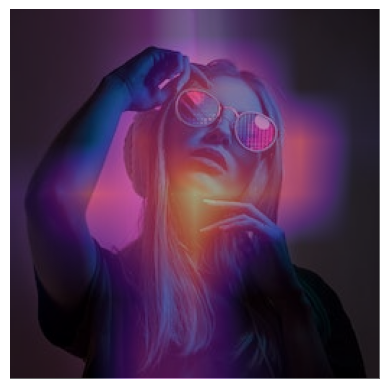

In [22]:
img = download_image(face_url)
a.predict(img)
a.gradcam_vis(img)

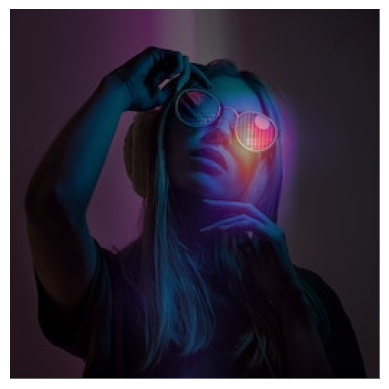

In [23]:
img = download_image(face_url)
a.predict(img, cls=836)
a.gradcam_vis(img)

In [24]:
a = GradCam(resnet, 'layer4', inference,transforms=preprocess)

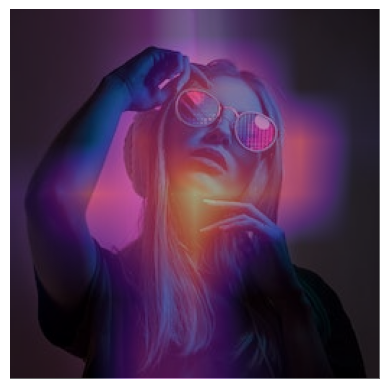

In [25]:
a.predict(img)
a.gradcam_vis(img)

In [26]:
# RF5

In [27]:
from rf5.danbooru_resnet import resnet50
import json

In [28]:
model = resnet50()
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(360),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.7137, 0.6628, 0.6519], std=[0.2970, 0.3017, 0.2979]),
])

/Users/davidgillespie/opt/anaconda3/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/davidgillespie/opt/anaconda3/envs/fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [29]:
a = GradCam(model, ['0'], inference,layer_idx=-1, transforms=preprocess)

In [30]:
danbooru_tags = {v:k for k,v in enumerate(json.load(open('rf5/class_names_6000.json','rb')))}
danbooru_tags2 = {k:v for k,v in enumerate(json.load(open('rf5/class_names_6000.json','rb')))}

In [31]:
danbooru_tags['breasts']

5

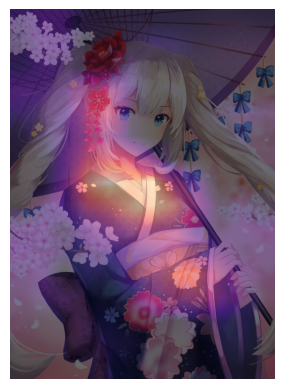

In [32]:
img = download_image('https://github.com/RF5/danbooru-pretrained/blob/master/img/egpic2.jpg?raw=true')
out = a.predict(img, cls=183)
a.gradcam_vis(img)

In [33]:
out = torch.sigmoid(out)

In [34]:
tags = {}
for i, o in enumerate(out.squeeze()):
    if o > 0.4:

        tags[danbooru_tags2[i]] = i

In [35]:
tags

{'age_rating_s': 0,
 '1girl': 1,
 'solo': 2,
 'long_hair': 3,
 'highres': 4,
 'smile': 7,
 'looking_at_viewer': 9,
 'blue_eyes': 12,
 'hair_ornament': 28,
 'bangs': 37,
 'eyebrows_visible_through_hair': 64,
 'silver_hair': 83,
 'flower': 85,
 'japanese_clothes': 103,
 'hair_flower': 180,
 'kimono': 183,
 'wide_sleeves': 204,
 'petals': 272,
 'sash': 285,
 'obi': 456,
 'floral_print': 566,
 'cherry_blossoms': 570,
 'oriental_umbrella': 1560}

# CLIP

In [36]:
import clip

In [37]:
model, preprocess = clip.load('RN50', device='cpu')

In [38]:
class GradCamClip(GradCam):
    
    def predict(self,  img, target):
        img = self.transforms(img)
        
        if len(img.shape)!=4:
            img = img[None,...]
            
        with Hook(self.mod, hook_func) as hook:
            output = self.model_predict(self.model, img)
 
            output.backward(target)
            self.act = hook.act.detach().squeeze().cpu()
            self.grad = hook.grad.detach().squeeze().cpu()
            
    def gradcam_vis(self, img, ):
        cam_map = self.gradcam()
        ax = show_image(img)
        ax.imshow(cam_map.squeeze().detach().numpy(), alpha=0.6, extent=(0,img.width, img.height,0),
              interpolation='bilinear', cmap='magma');
        return cam_map

In [39]:
a = GradCamClip(model.visual, 'layer4', inference,transforms=preprocess)

In [40]:
img = download_image(face_url)

In [45]:
image_caption = ['the shades']
text_input = clip.tokenize(image_caption)
target = model.encode_text(text_input).float()

In [46]:
trs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=224),
    torchvision.transforms.CenterCrop(size=(224,224))
])

In [47]:
img2 = trs(img)

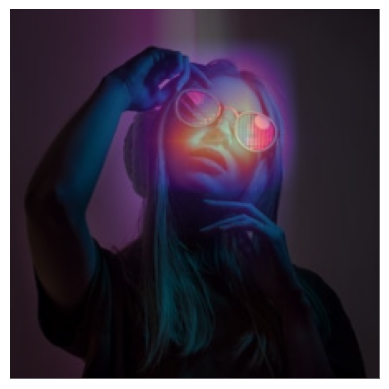

In [48]:
a.predict(img, target)
cam_map = a.gradcam_vis(img2)